In [1]:
from transformers import ViTForImageClassification
import warnings
from PIL import Image # if will be need one pictures from dataset
warnings.filterwarnings(action='ignore')
from data.camMethods import imageMapping
from data.camMethods import preprocessingImage
from data.transformerResearch import gradForLayerNormLastLayer
from data.transformerResearch import weightsAfterPassFromViTAttention
from data.transformerResearch import gradForViTAttentionLastLayer
from data.transformerResearch import attentionCamSimilar
import torch
import torch.nn as nn

import skimage.transform
import matplotlib.pyplot as plt
from torchvision import transforms

%load_ext autoreload
%autoreload 2


In [2]:
# Will be use ONE picture
PATH_TO_SET = 'dataset/mergeDataset'

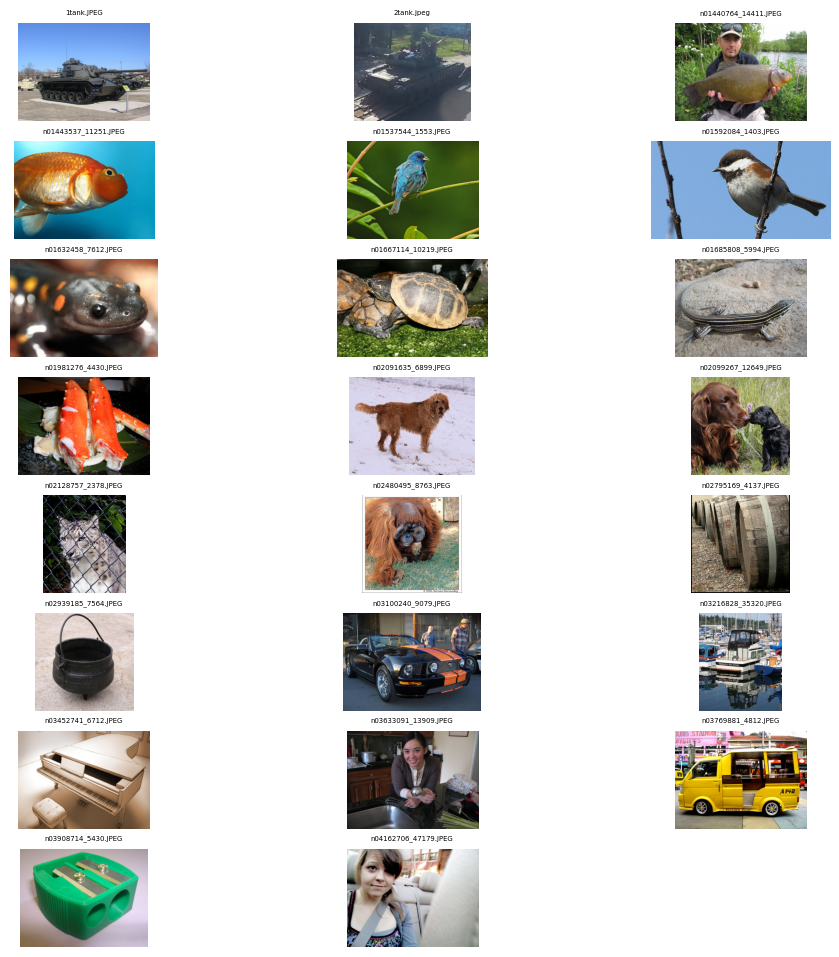

In [3]:
listImage = imageMapping(PATH_TO_SET)

In [4]:
preprocessingList = preprocessingImage(listImage)

In [5]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

In [6]:
# Coincidentally gather picture
rawImage = listImage[4]
testImage = preprocessingList[4] # [1, 3, 224, 224]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

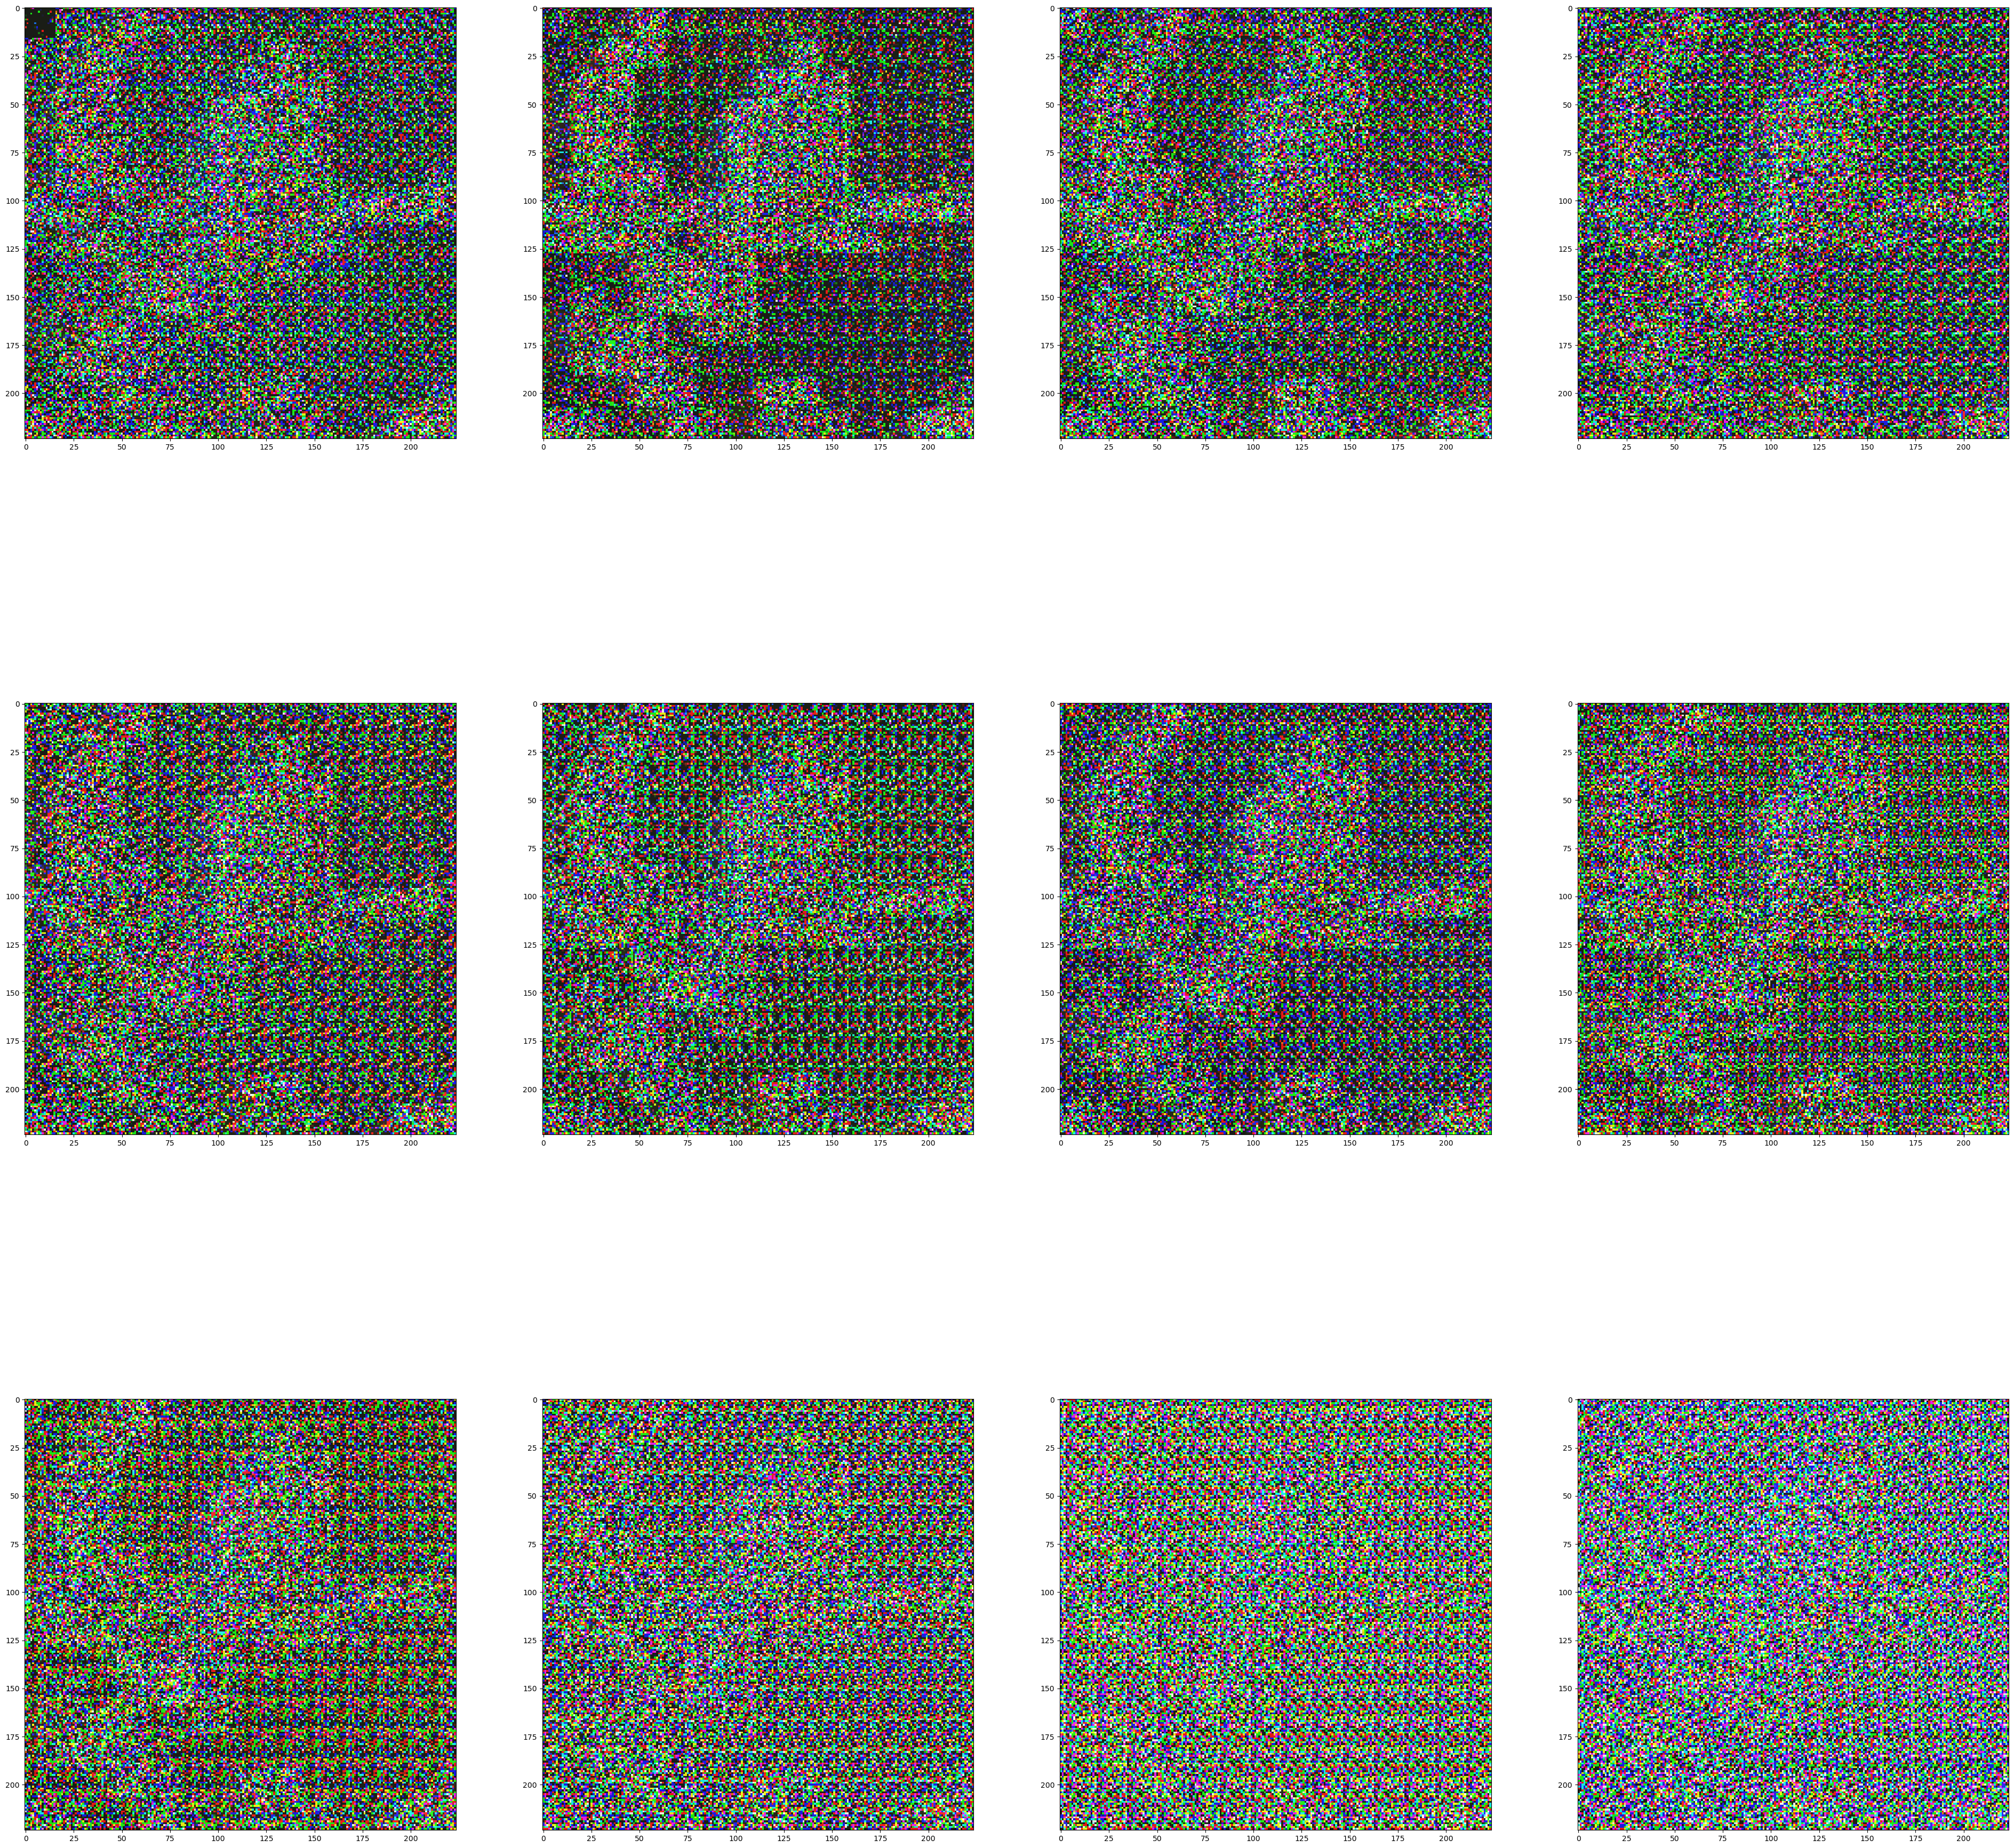

In [7]:
listOfAttentionWeightAfterPass = weightsAfterPassFromViTAttention(model, testImage, rawImage)

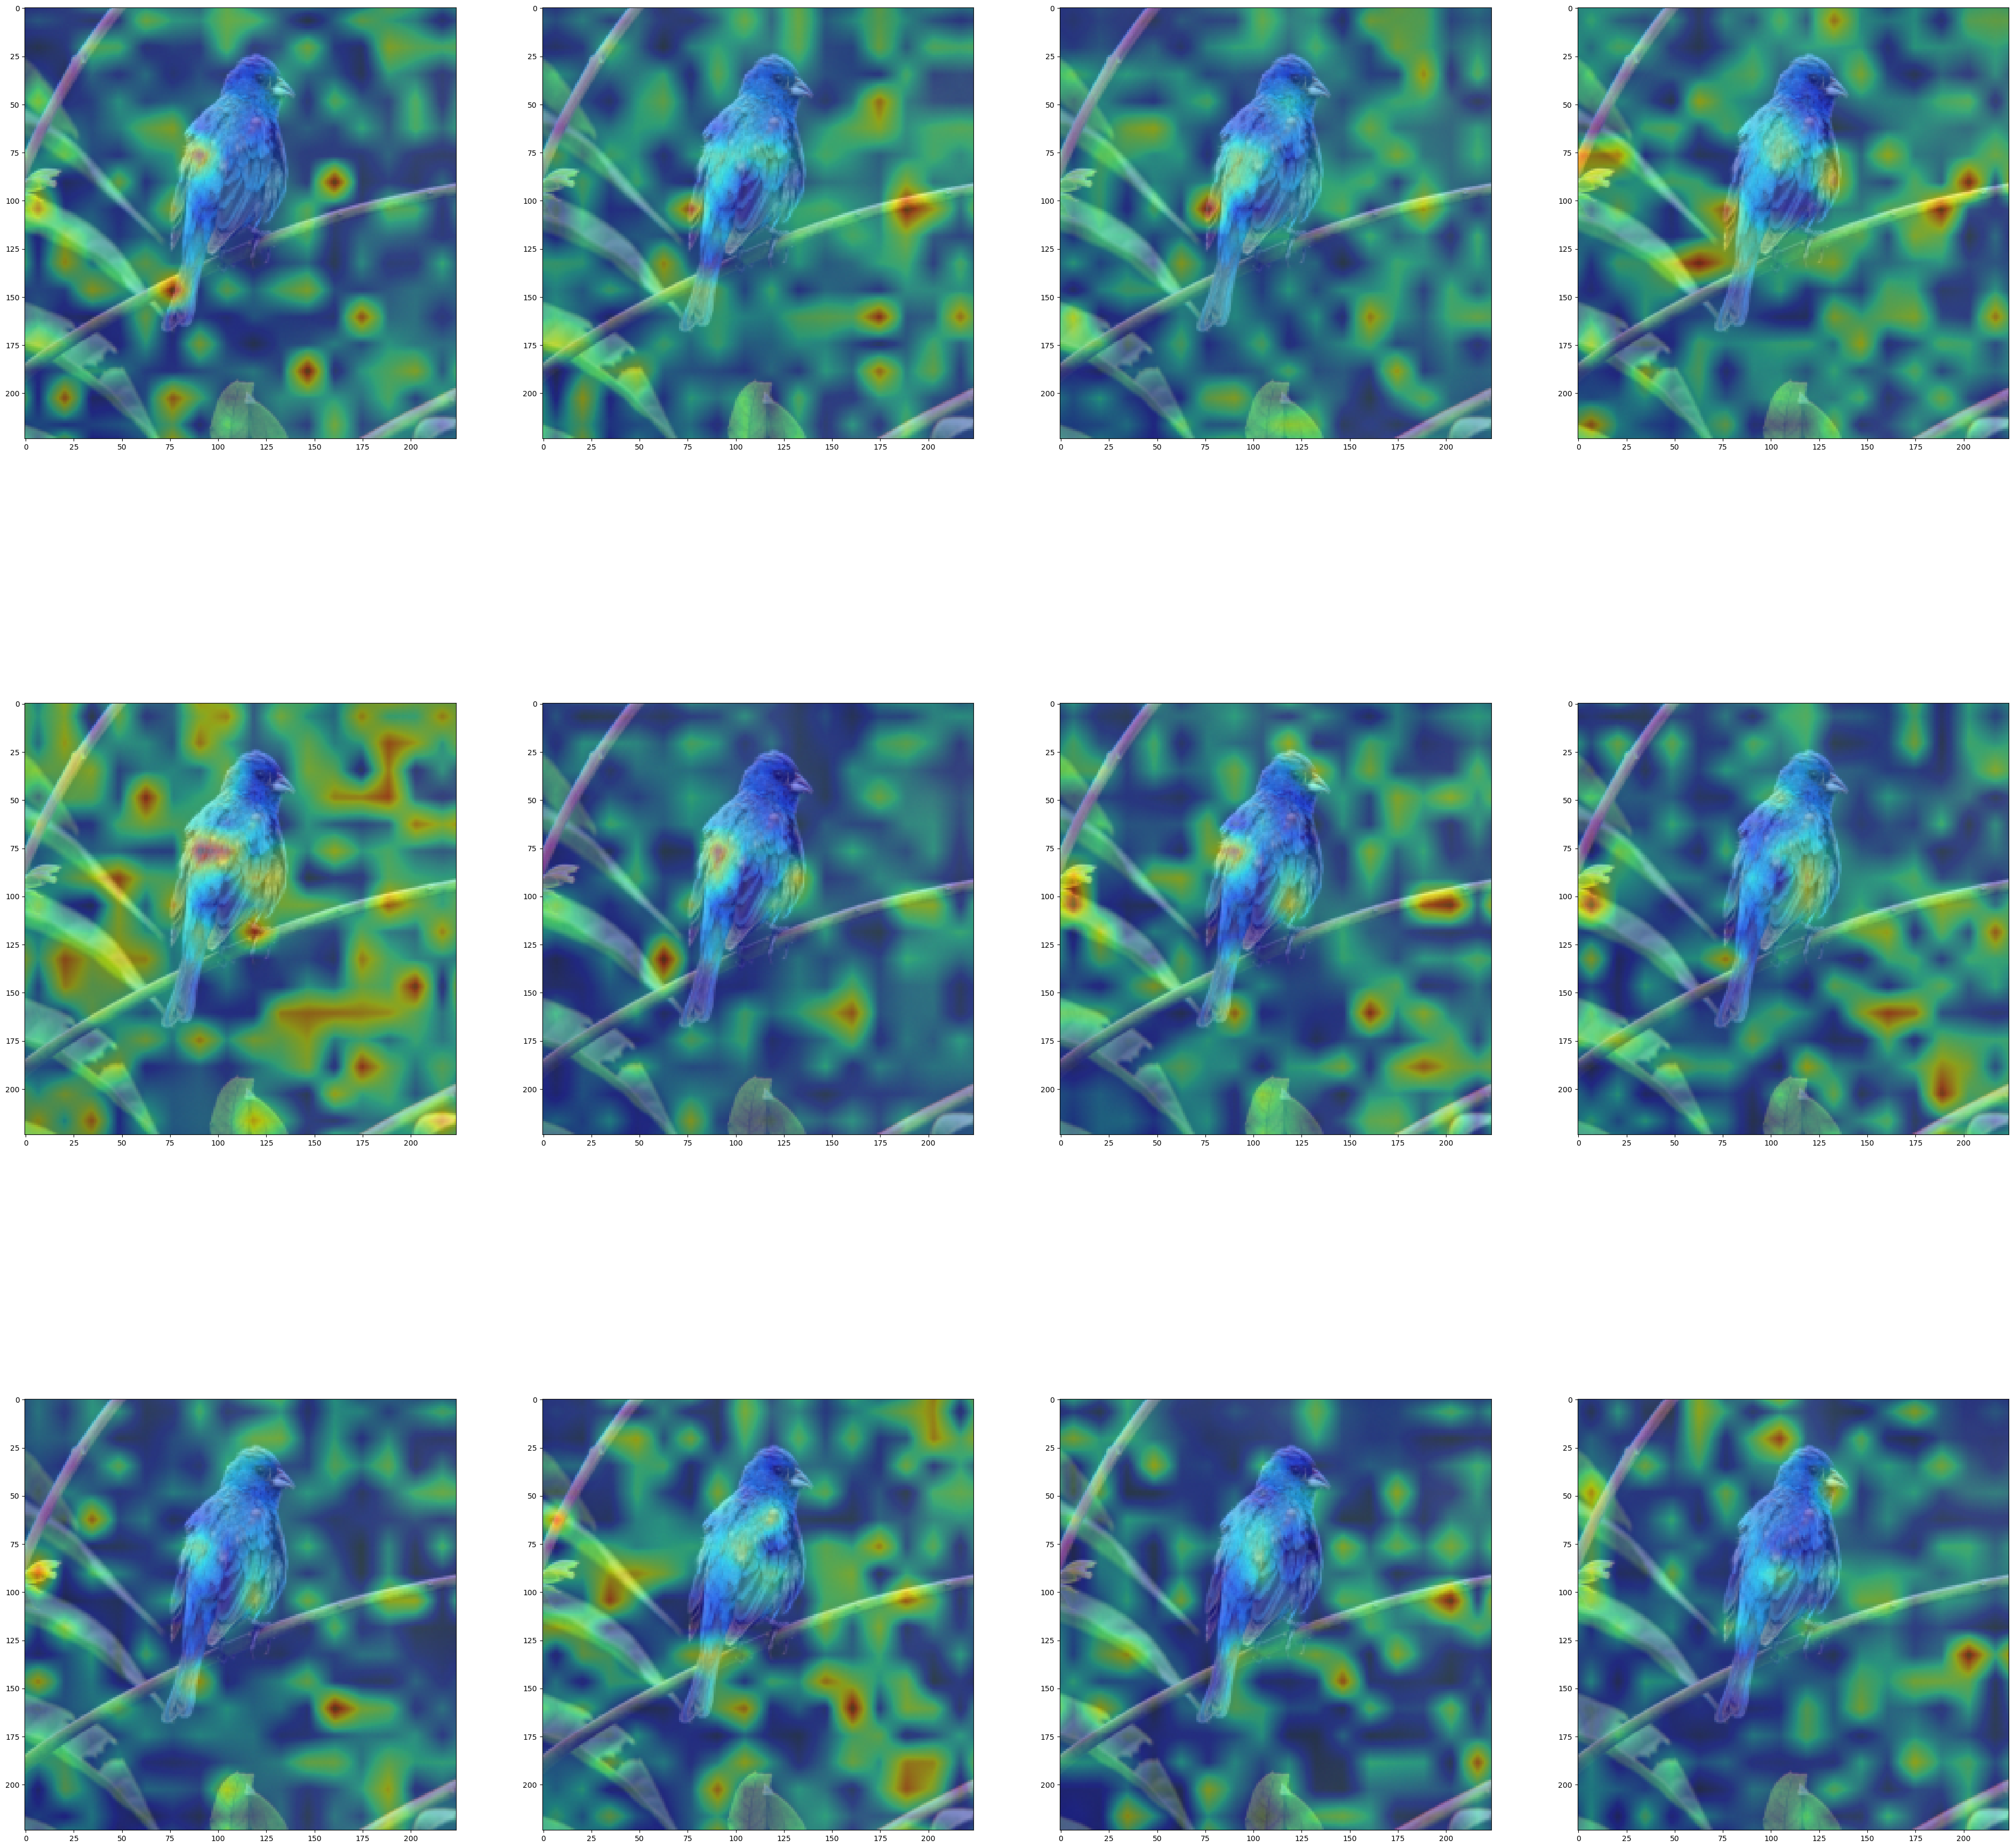

In [18]:
attentionLastLayer = attentionCamSimilar(model, listOfAttentionWeightAfterPass, testImage, rawImage)

[tensor([[0.5644, 0.7950, 0.7638, 0.6539, 0.4813, 1.0132, 0.7973, 0.9381, 0.6122,
          0.6235, 0.6713, 0.7588, 0.9515, 0.7369, 0.5984, 0.8265, 0.6376, 0.7406,
          0.8500, 0.7463, 0.7280, 0.6378, 0.8668, 0.7632, 0.8580, 0.5724, 0.7200,
          0.8275, 0.7058, 0.8111, 0.8158, 0.5187, 0.6820, 0.7446, 0.6869, 0.7838,
          0.7856, 0.8290, 0.8320, 0.4542, 0.7445, 0.7697, 0.4660, 0.5913, 0.7766,
          1.0246, 0.8161, 0.6345, 0.6308, 0.7167, 0.7417, 0.8298, 0.4832, 0.6071,
          0.8599, 0.8760, 0.7452, 0.7786, 0.5940, 0.8916, 0.9235, 0.3565, 0.6945,
          0.7939, 0.7812, 0.6253, 0.8971, 0.6956, 0.5223, 0.7533, 0.6890, 0.6677,
          0.8924, 0.6181, 0.7405, 0.8347, 0.5761, 1.0742, 0.9681, 0.7499, 0.7141,
          0.8174, 0.8131, 0.7533, 0.7889, 0.7608, 0.7325, 0.5074, 1.0228, 0.6210,
          0.5918, 0.9300, 0.8799, 0.7998, 0.6945, 0.5073, 0.6804, 0.7835, 0.9339,
          0.9752, 0.8667, 0.9310, 0.7166, 0.5647, 0.8837, 0.6975, 0.5191, 0.6412,
          0.8081

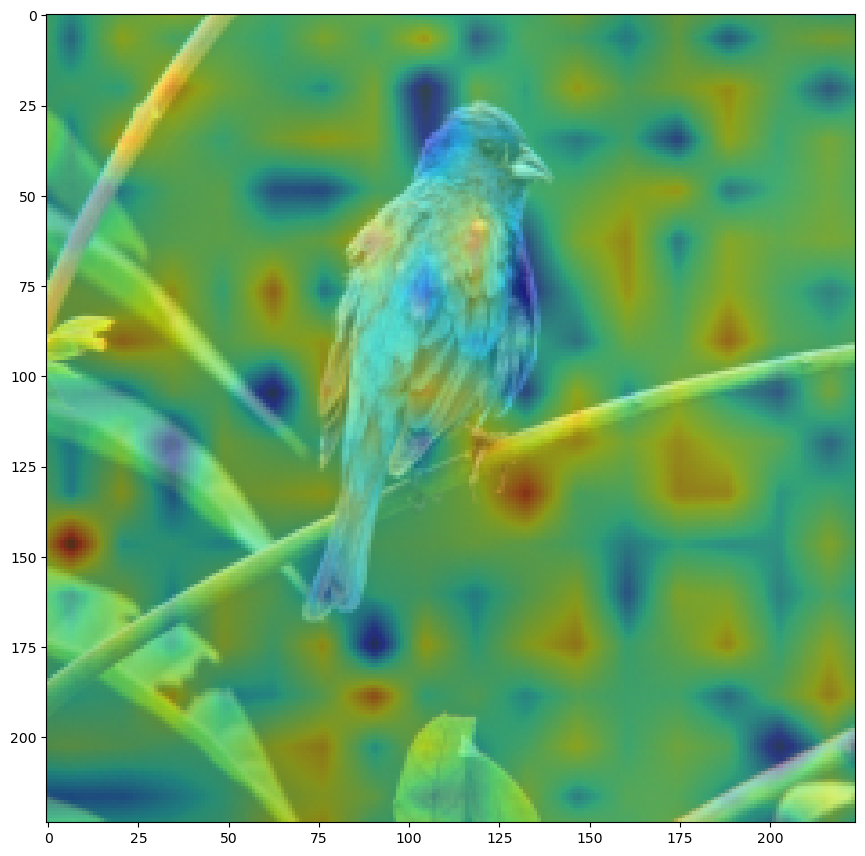

In [19]:
class Changer(nn.Module):
    def __init__(self):
        super(Changer, self).__init__()
    def forward(self, x):
        return x['last_hidden_state']
hiddenStateLayer = nn.Sequential(*(list(model.children())[:-1] + [Changer()]))
hiddenWeight = hiddenStateLayer(testImage)
attentionCamSimilar(model, [hiddenWeight], testImage, rawImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


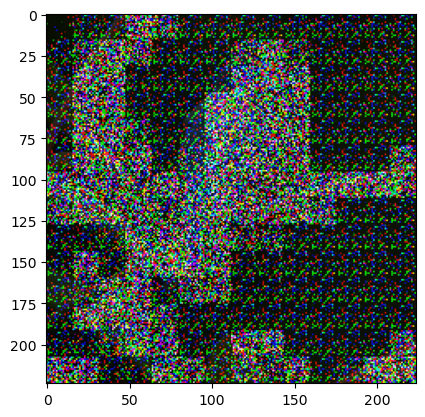

In [10]:
# RESTORE AFTER EMB FOR ARTICLE
import torchvision
import numpy as np

def restoreFromPatches224(patches: np.ndarray, kernelSize: int = 16, stride: int = 16) -> None:
    #input array: [batch] x [196or197] x [768] , 197th is position embedding, settled in last row
    _, x, _ = patches.size()
    if x == 197:
        patches = patches[:, :-1, :]
    patchReshape = patches.reshape(1, 14, 14, 3, kernelSize, stride)  #torch.Size([1, 3, 14, 14, 16, 16])
    patchReshape = patchReshape.permute(0, 3, 1, 2, 4, 5)             #torch.Size([1, 3, 14, 14, 16, 16])
    # batch, c, h, w
    unfoldShape = patchReshape.size()
    patchesOriginal = patchReshape.view(unfoldShape)
    outputH = unfoldShape[2] * unfoldShape[4] # 14 x 16 = 224
    outputW = unfoldShape[3] * unfoldShape[5] # 14 x 16 = 224
    patchesOriginal = patchesOriginal.permute(0, 1, 2, 4, 3, 5).contiguous()
    patchesOriginal = patchesOriginal.view(1, 3, outputH, outputW).squeeze(0)
    norm = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    return norm(patchesOriginal)
embImage = model._modules.get('vit').get_submodule('embeddings')(testImage)
plt.imshow(transforms.Compose([transforms.Resize((224, 224))])(rawImage))
plt.imshow(restoreFromPatches224(embImage).detach().numpy().squeeze().transpose(1,2,0), alpha=0.8, cmap='jet')

torch.Size([1, 768])


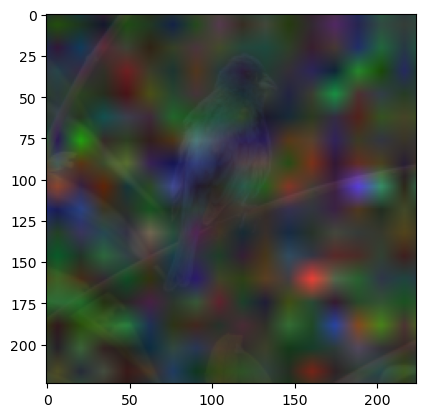

In [20]:
sumOfHead = torch.zeros(768)
print(attentionLastLayer[0].shape)
for i in range(len(attentionLastLayer)):
    sumOfHead += attentionLastLayer[i].squeeze(0)
sumOfHead = sumOfHead - torch.min(sumOfHead)
sumOfHead = sumOfHead / torch.max(sumOfHead)
plt.imshow(transforms.Compose([transforms.Resize((224, 224))])(rawImage), alpha=0.8)
plt.imshow(skimage.transform.resize(sumOfHead.reshape(3, 16, 16).permute(1,2,0).detach().numpy(),                                                       [224, 224]), alpha=0.9, cmap='jet')

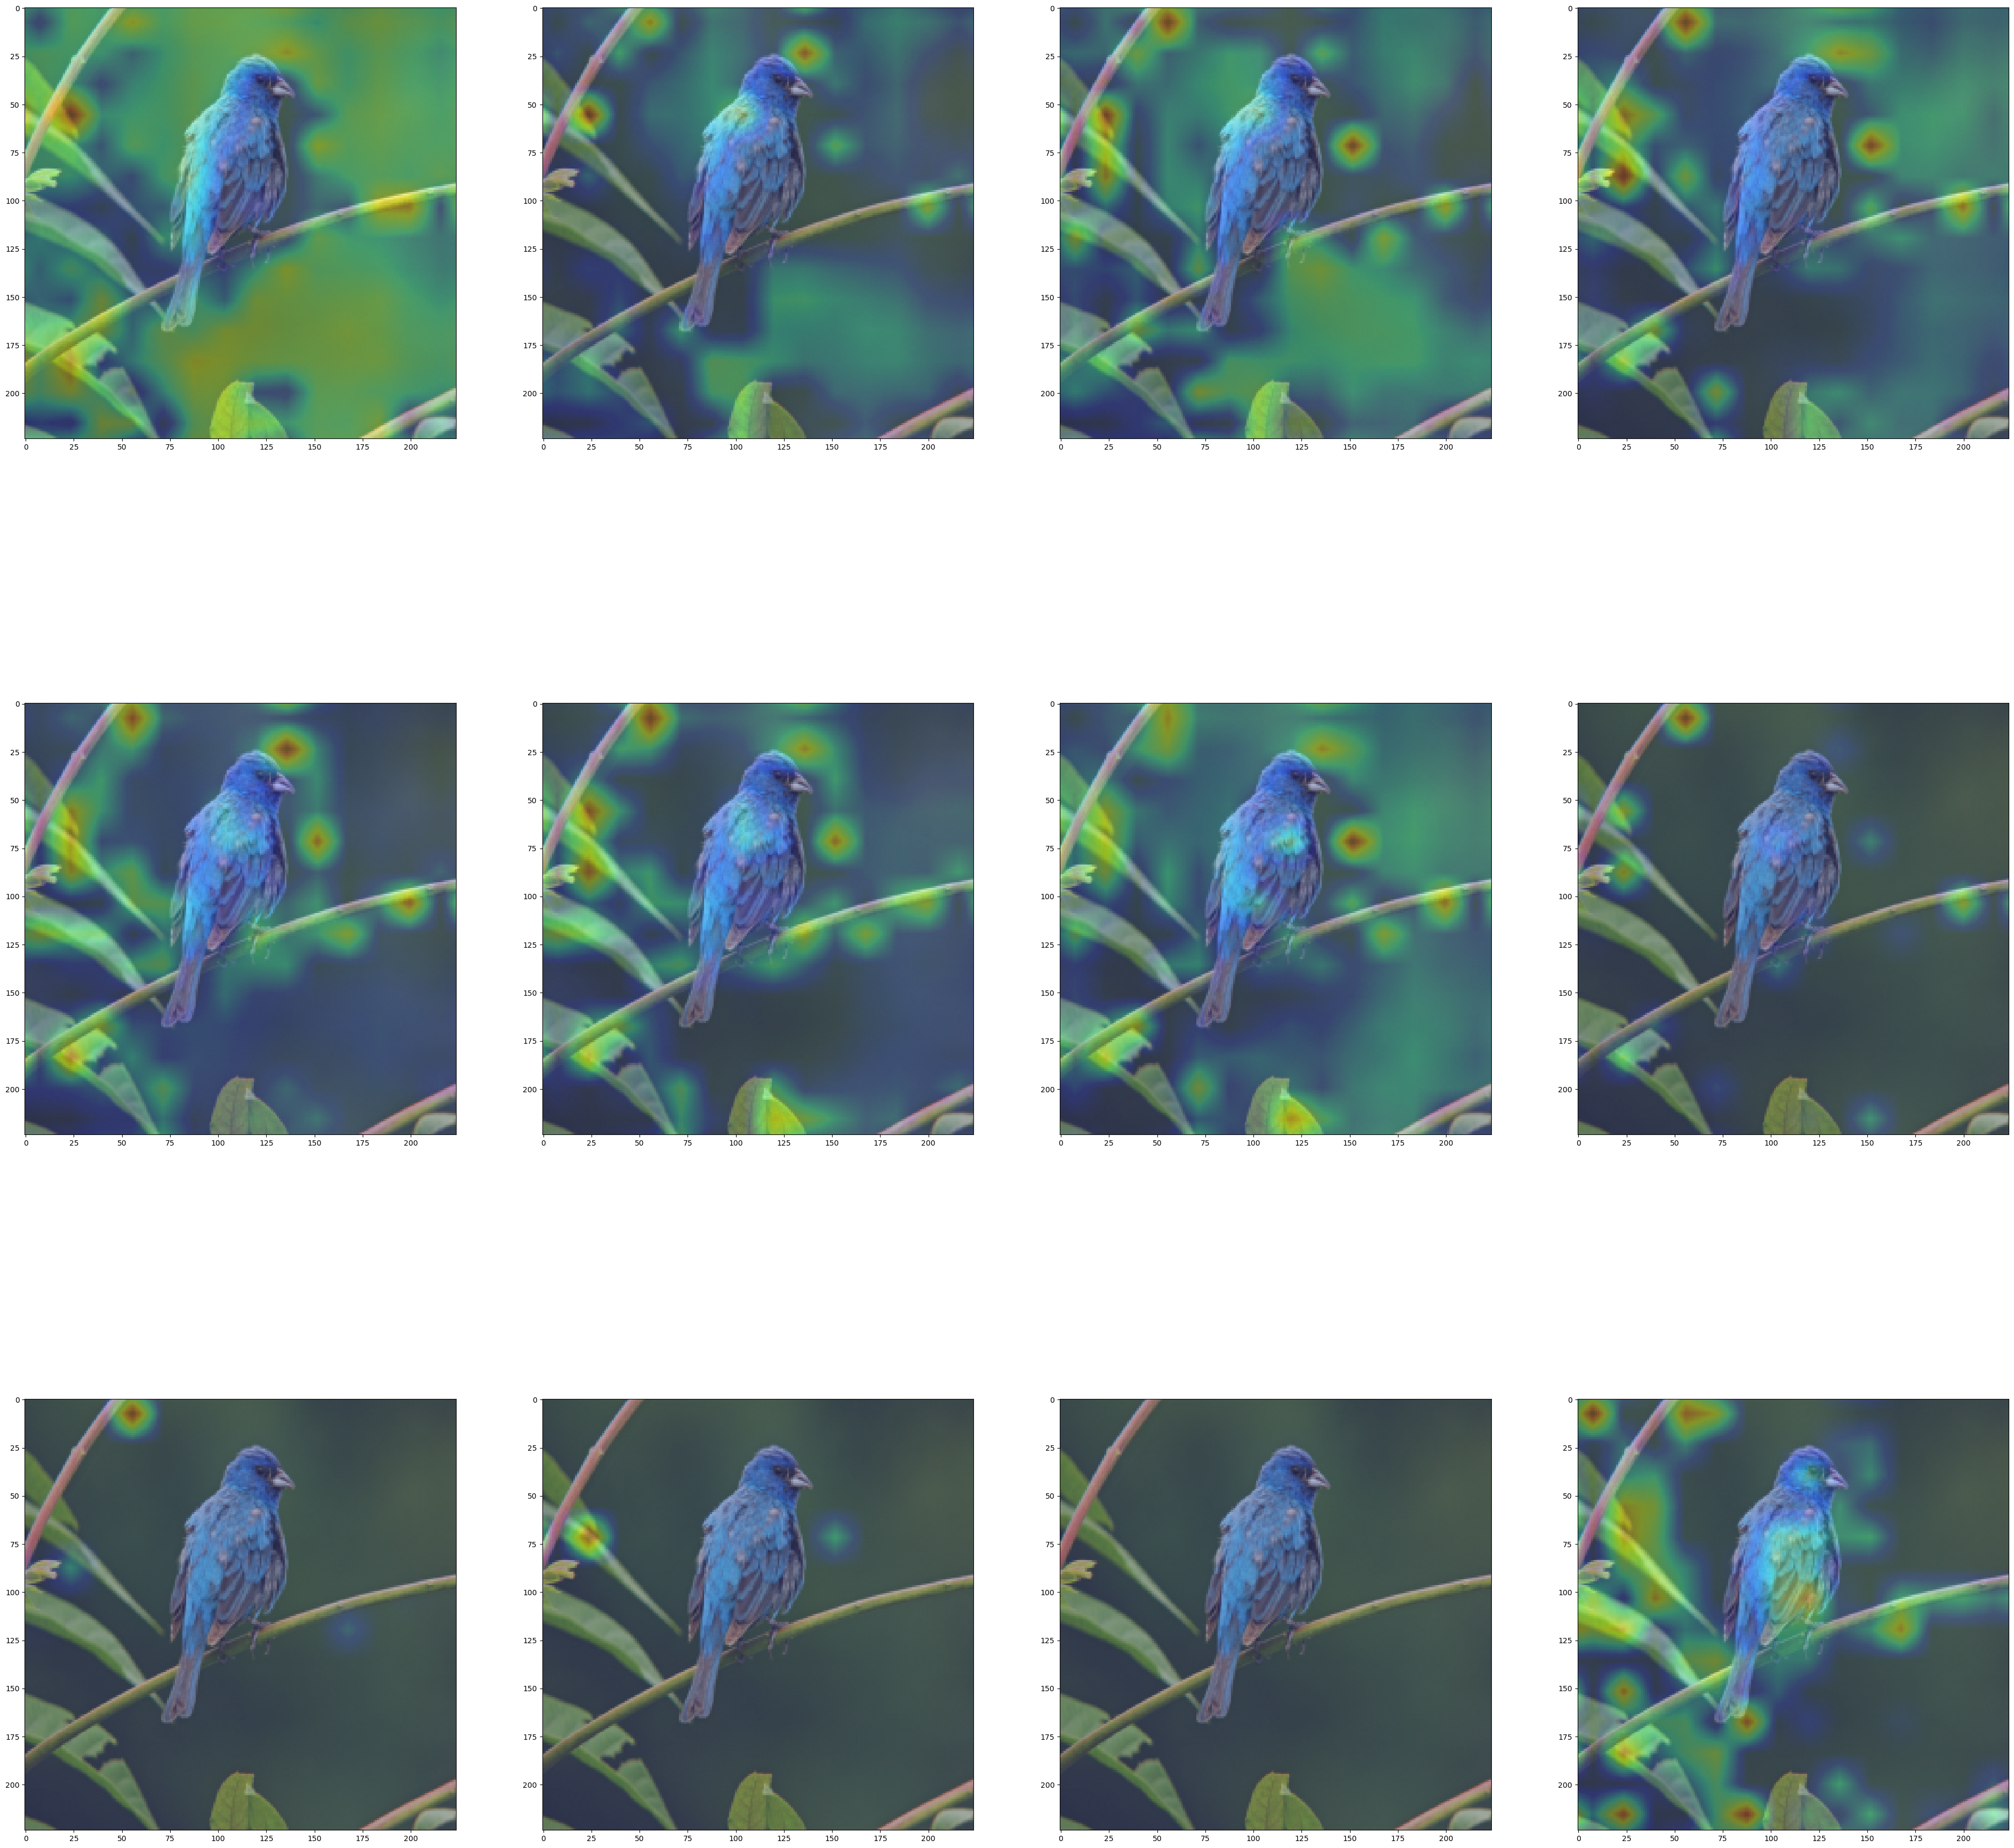

In [12]:
attentionVitLayer = gradForViTAttentionLastLayer(model, testImage, rawImage)


tensor([[[-0.0212,  0.0210,  0.0024,  ..., -0.0088,  0.0135,  0.0468],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

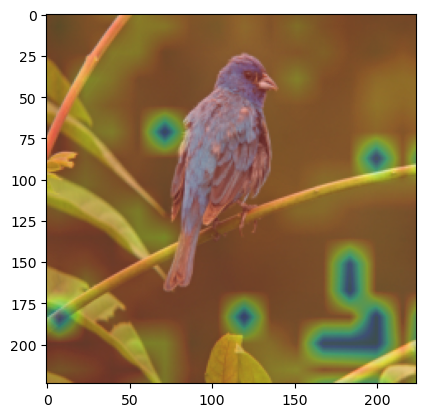

In [13]:
gradForLayerNormLastLayer(model, testImage, rawImage)

tensor([[12.4564,  4.6111,  3.4425, 34.4631, 12.6673,  5.2031,  5.1072,  4.6468,
          3.9967,  4.1648,  5.1970,  5.4586,  5.0169,  4.0871],
        [ 4.2380,  5.9469,  7.5276,  9.6236,  4.0406,  5.1326,  5.3644,  6.4891,
         20.1645, 11.1073,  4.7586,  5.1663,  4.5026,  3.2623],
        [ 3.8409,  8.8737,  6.6350,  3.1771,  4.5314,  5.5861,  4.8205,  6.2473,
          1.1064, 11.1809,  4.8095,  5.6071,  4.6544,  3.3378],
        [ 3.9030, 30.1055, 13.1865,  3.9722,  4.4790,  5.7855,  7.3007,  0.0000,
          3.9785,  2.8701,  5.5233,  6.2080,  4.8535,  3.8176],
        [ 4.2377, 21.3353,  8.1047,  4.9743,  3.8621,  5.3576,  9.5743,  8.5051,
          3.5698, 24.3970,  5.2135,  5.9023,  4.5835,  4.0283],
        [ 3.9353, 22.6936,  9.4105, 10.9191,  3.5271,  6.7672,  4.8412,  5.3806,
          0.4338,  1.8443,  4.2108,  5.1659,  4.0030,  6.3989],
        [ 7.2767,  3.9477,  8.8175, 10.5094,  6.3877,  4.5135,  7.3541, 10.6748,
          2.6793,  6.2171,  5.1760, 10.0238, 23.1

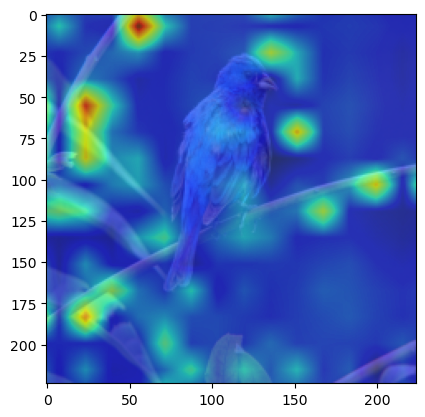

In [14]:
sumOfHeadGrad = torch.zeros(14, 14)
for i in range(len(attentionVitLayer)):
    sumOfHeadGrad += attentionVitLayer[i]
cam = sumOfHeadGrad - torch.min(sumOfHeadGrad)
cam = cam / torch.max(cam)
print(sumOfHeadGrad)
plt.imshow(transforms.Compose([transforms.Resize((224, 224))])(rawImage), alpha=0.8)
plt.imshow(skimage.transform.resize(cam.detach().numpy(),
                                                             [224,224]),
                                                             alpha=0.6,
                                                             cmap='jet')

In [15]:
import math
import os
from scipy.stats import logistic, expon, norm, pearsonr
from scipy import stats

def showStatisticalVis(path: str, features: torch.tensor, col : int =2) -> None:
    row = math.ceil(features.shape[0] / col)
    fig = plt.figure(figsize=(15, 15))
    listDir = os.listdir(path)
    for pcs in range(features.shape[0]):
        fig.add_subplot(row, col, pcs+1)
        plt.hist(features[pcs], bins='auto', density=True)
        plt.plot(np.sort(np.array(features[pcs])), norm.pdf(np.sort(np.array(features[pcs])),\
                          features[pcs].mean(),\
                          features[pcs].std()))

        plt.plot(np.sort(np.array(features[pcs])), logistic.pdf(np.sort(np.array(features[pcs])),\
                          features[pcs].mean(),\
                          features[pcs].std()))
        plt.plot(np.sort(np.array(features[pcs])), expon.pdf(np.sort(np.array(features[pcs])),\
                          features[pcs].mean(),\
                          features[pcs].std()))
        plt.title(
                   listDir[pcs] + \
                  '\nNorm statistic: '+ str(stats.kstest(np.sort(np.array(features[pcs])), \
                                                    norm.cdf(np.sort(np.array(features[pcs])),\
                                                      features[pcs].mean(),\
                                                      features[pcs].std())).statistic)
                  +

                  '\nLog statistic: '+ str(stats.kstest(np.sort(np.array(features[pcs])), \
                                  logistic.cdf(np.sort(np.array(features[pcs])),\
                                  features[pcs].mean(),\
                                  features[pcs].std())).statistic)
                  +

                  '\nExpon statistic: '+ str(stats.kstest(np.sort(np.array(features[pcs])), \
                                  expon.cdf(np.sort(np.array(features[pcs])),\
                                  features[pcs].mean(),\
                                  features[pcs].std())).statistic)
                  ,fontsize=7)

        plt.grid('on')
        plt.axis('on')

[None, None, None, None, None, None, None, None, None, None, None, None]

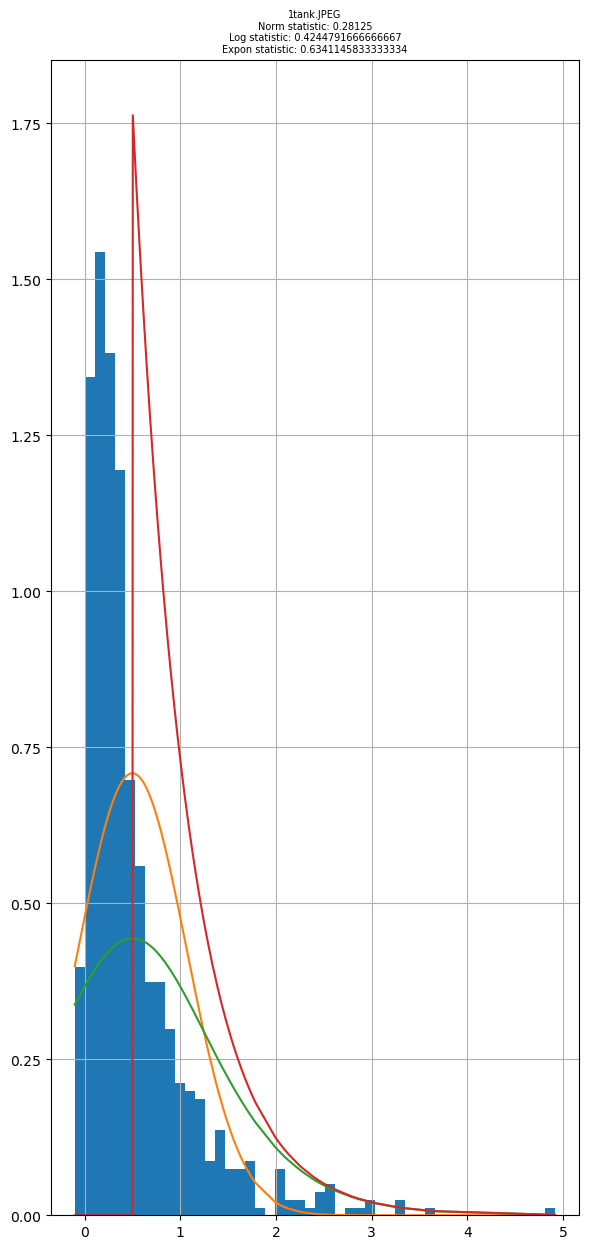

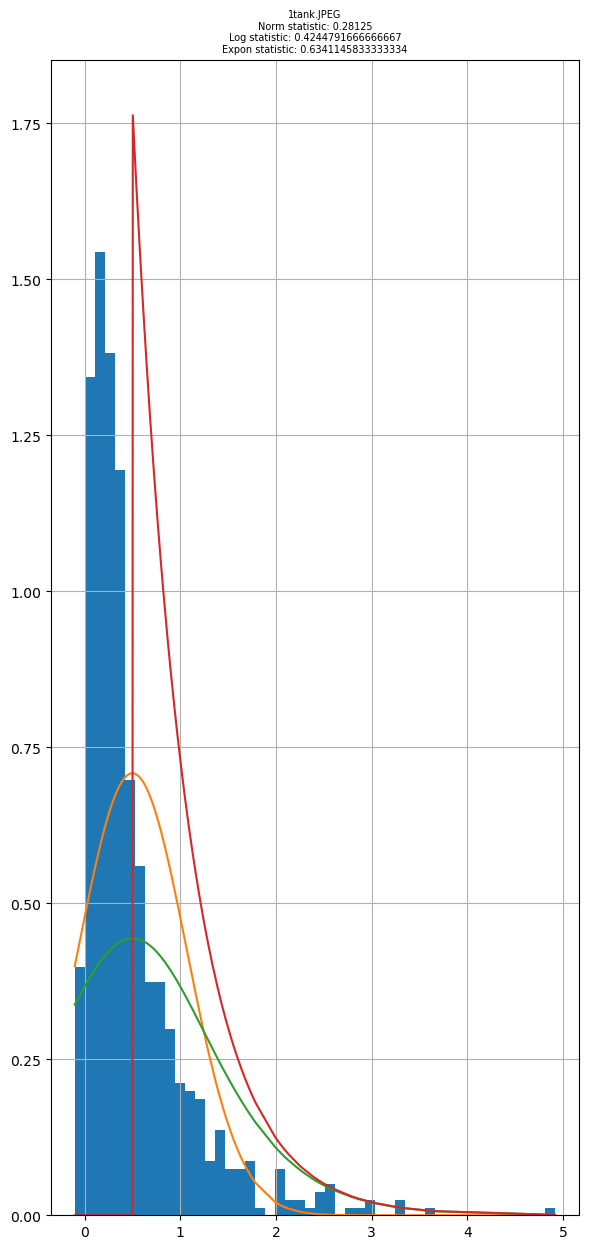

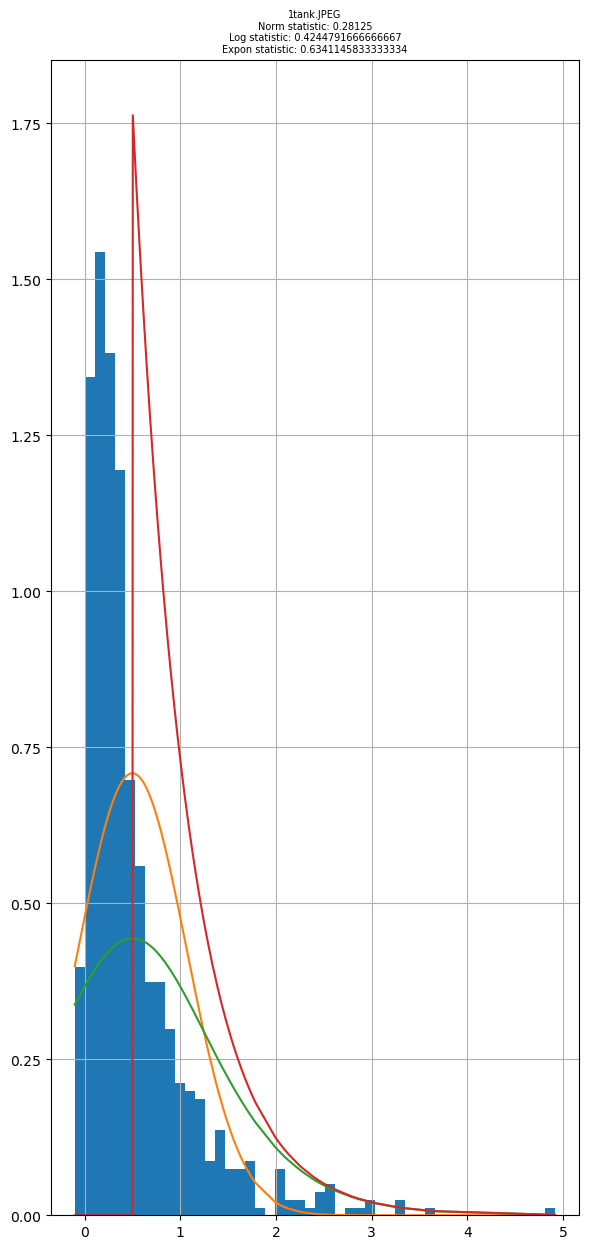

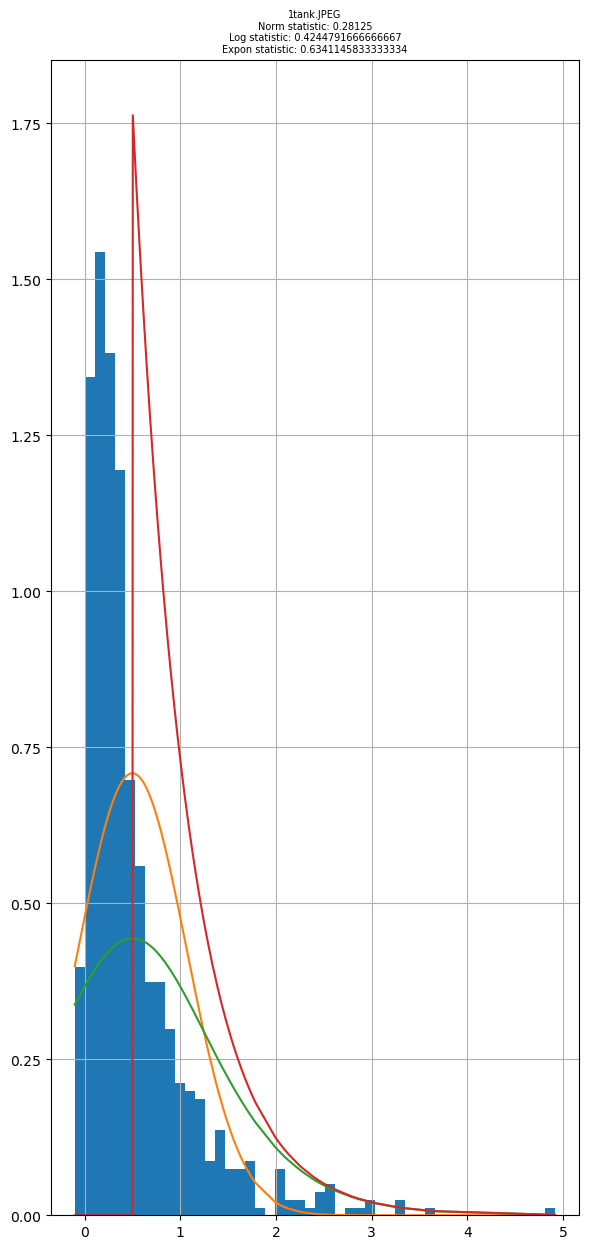

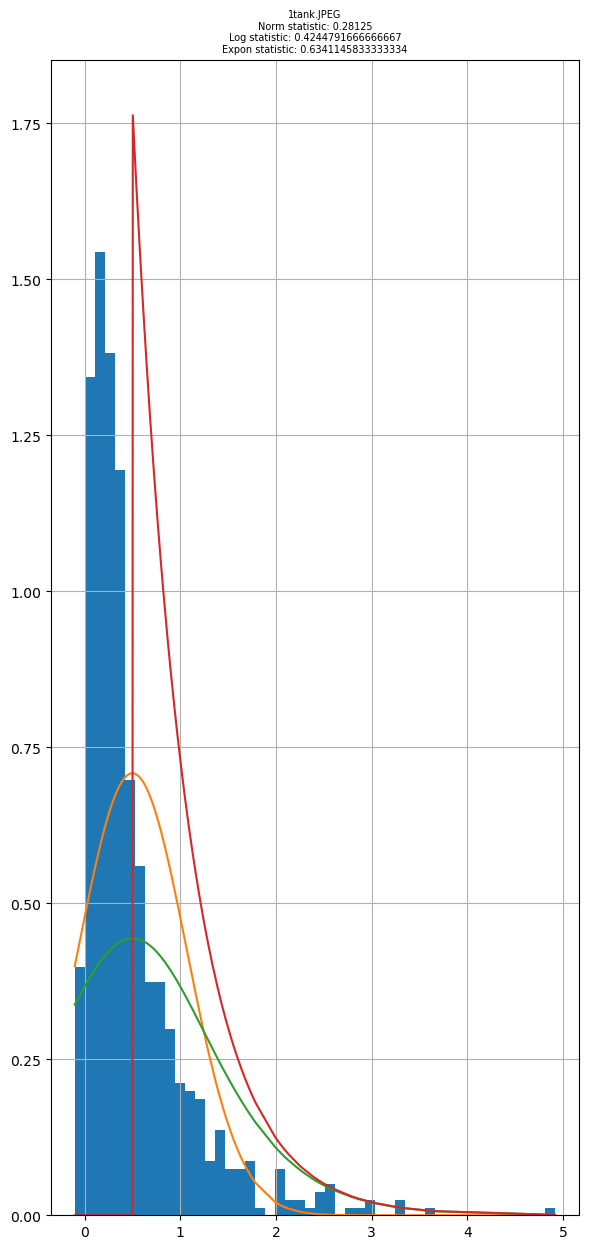

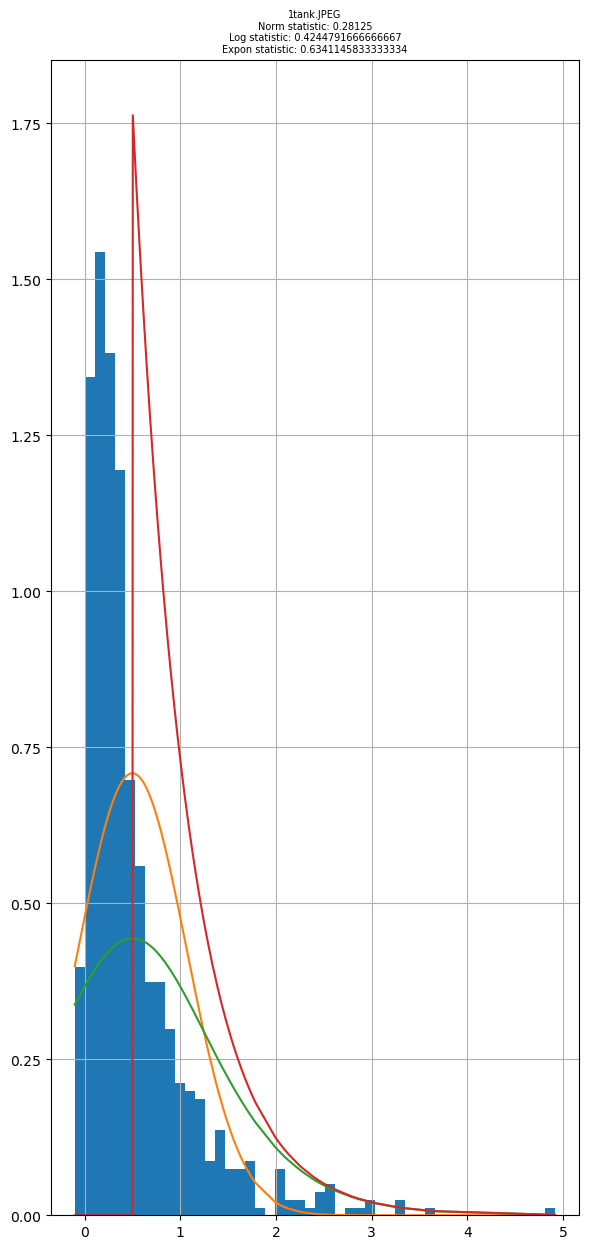

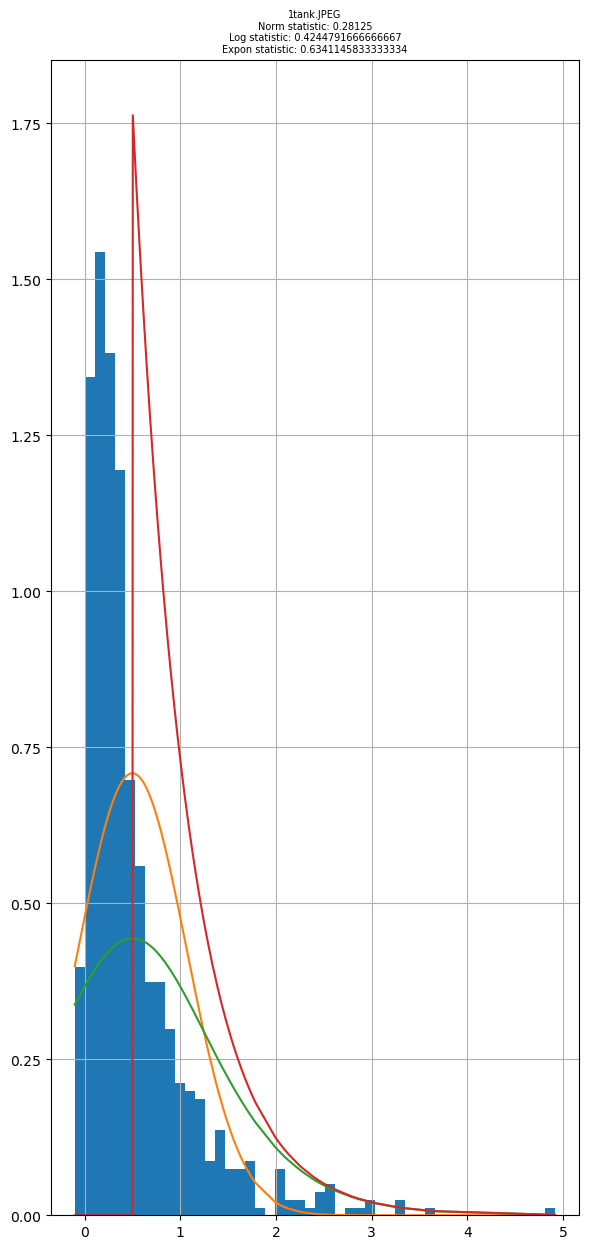

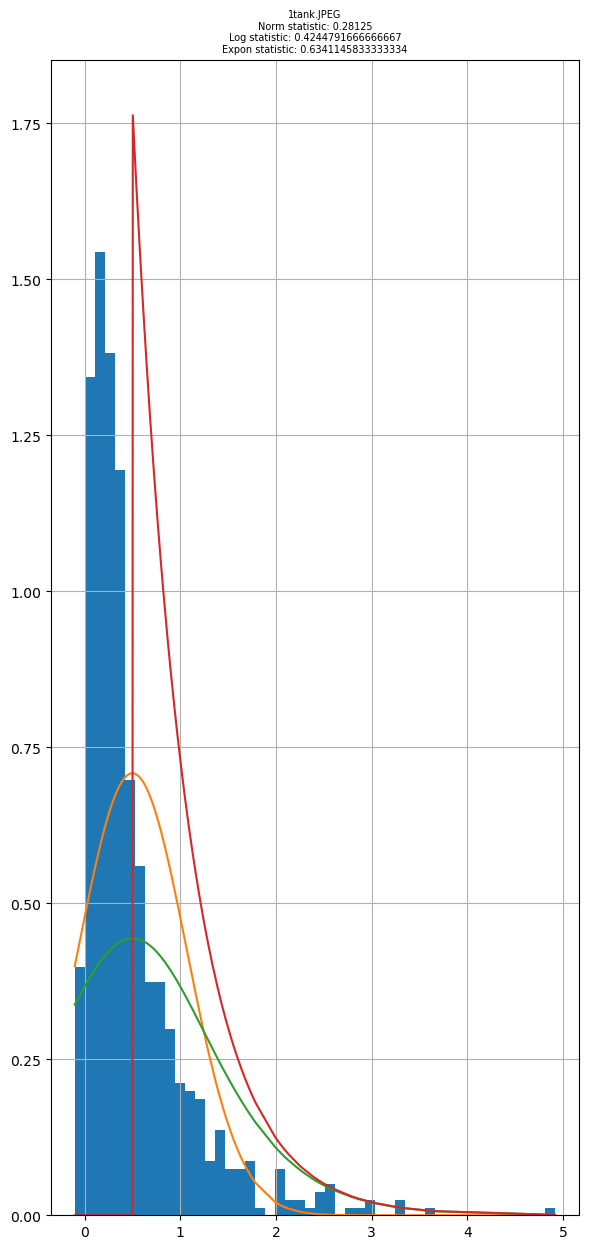

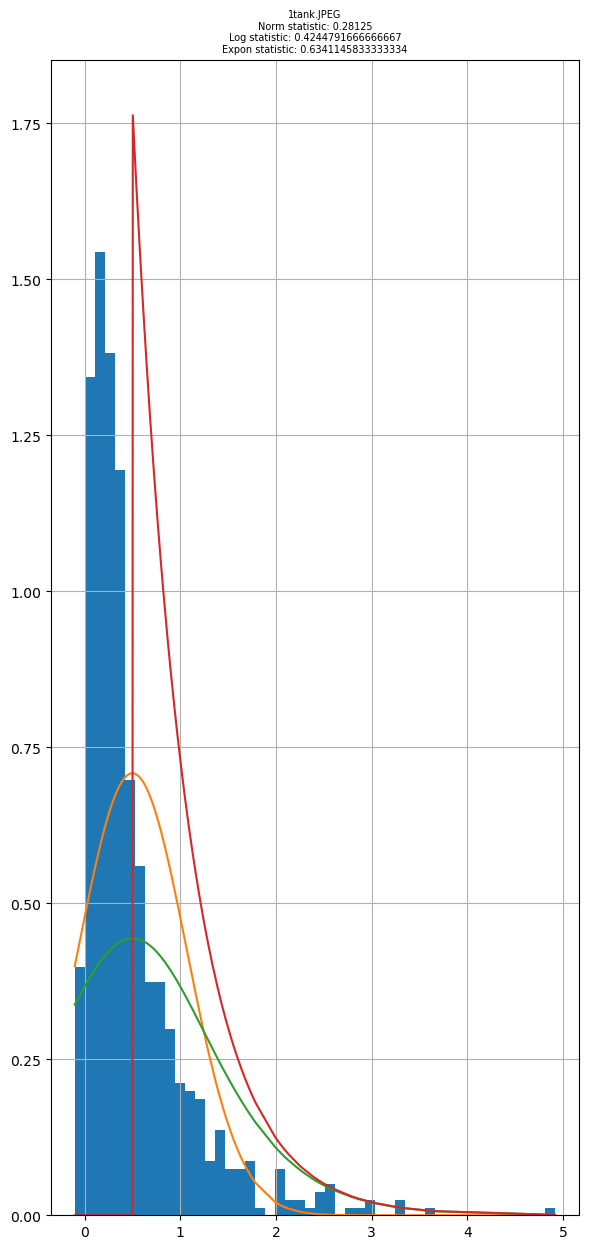

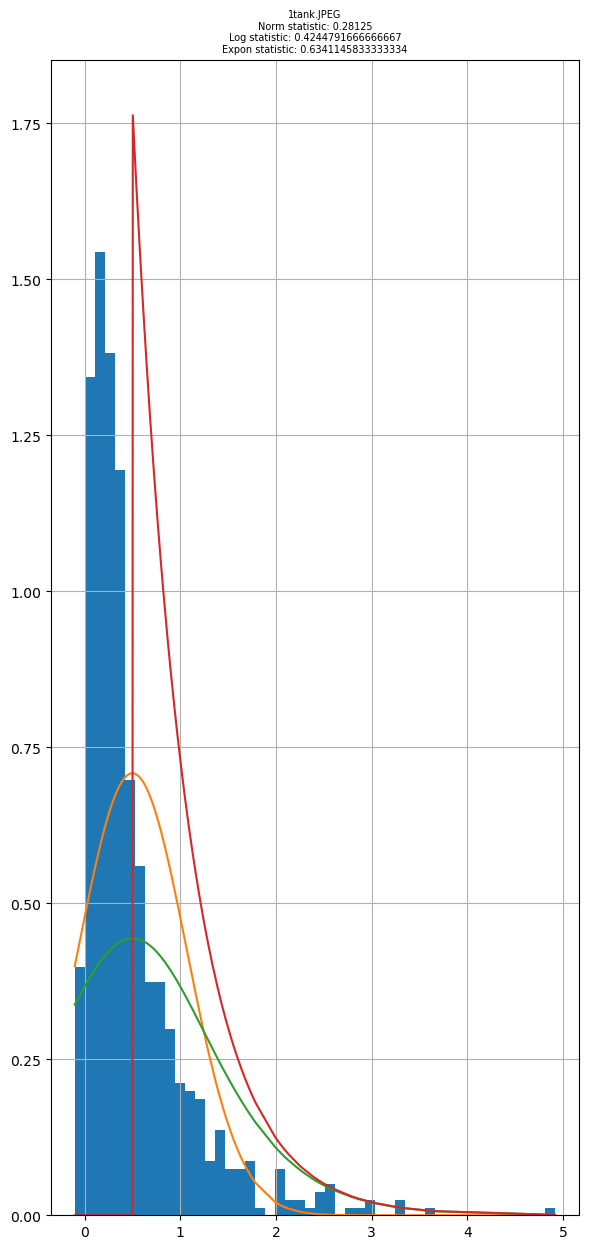

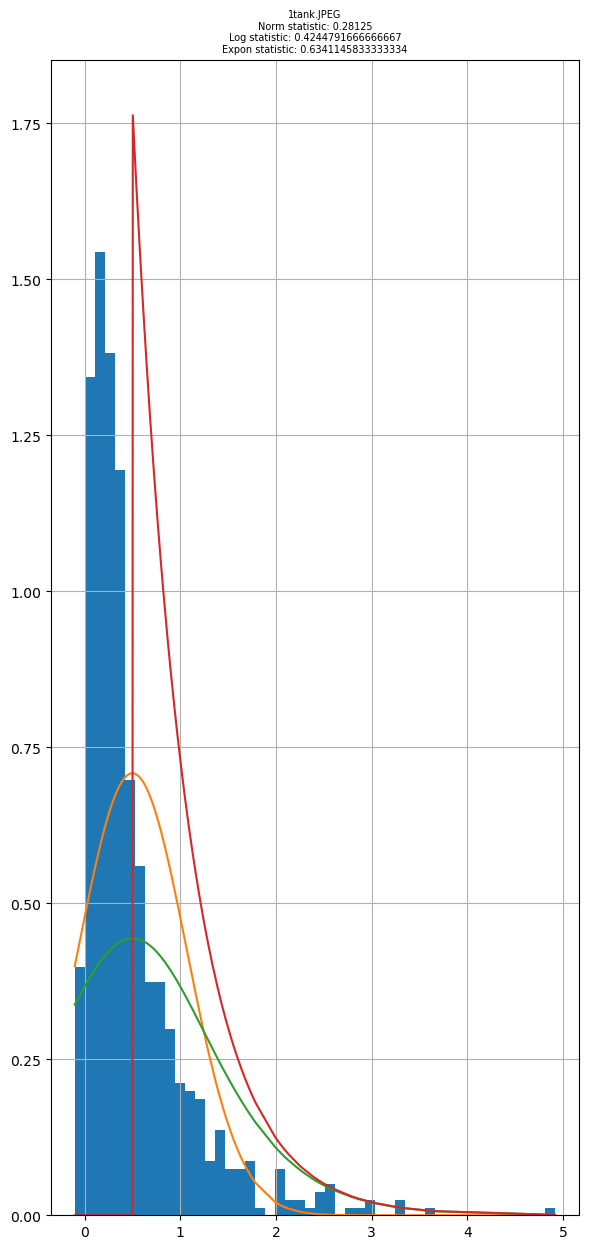

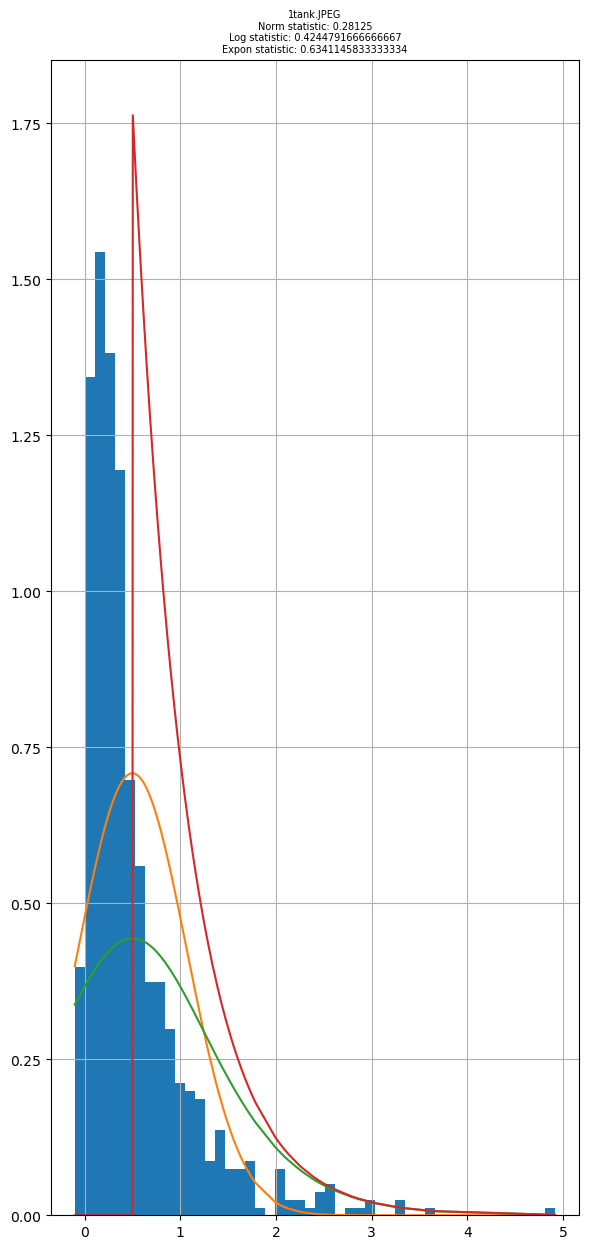

In [16]:

# [showStatisticalVis(PATH_TO_SET, listOfAttentionWeightAfterPass[i].detach().numpy().reshape(1, 197 * 768)) for i in range(len(listOfAttentionWeightAfterPass))]
[showStatisticalVis(PATH_TO_SET, listOfAttentionWeightAfterPass[0].mean(1).detach().numpy()) for i in range(len(listOfAttentionWeightAfterPass))]
# showStatisticalVis(PATH_TO_SET, embImage.detach().numpy().reshape(1, 197 * 768))

[None, None, None, None, None, None, None, None, None, None, None, None]

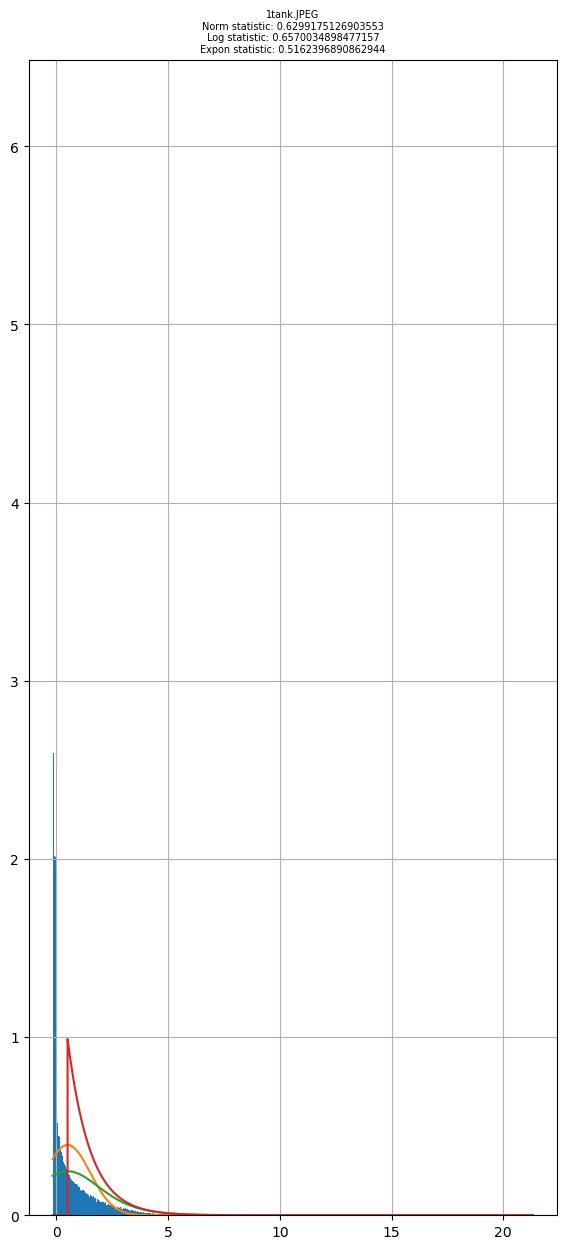

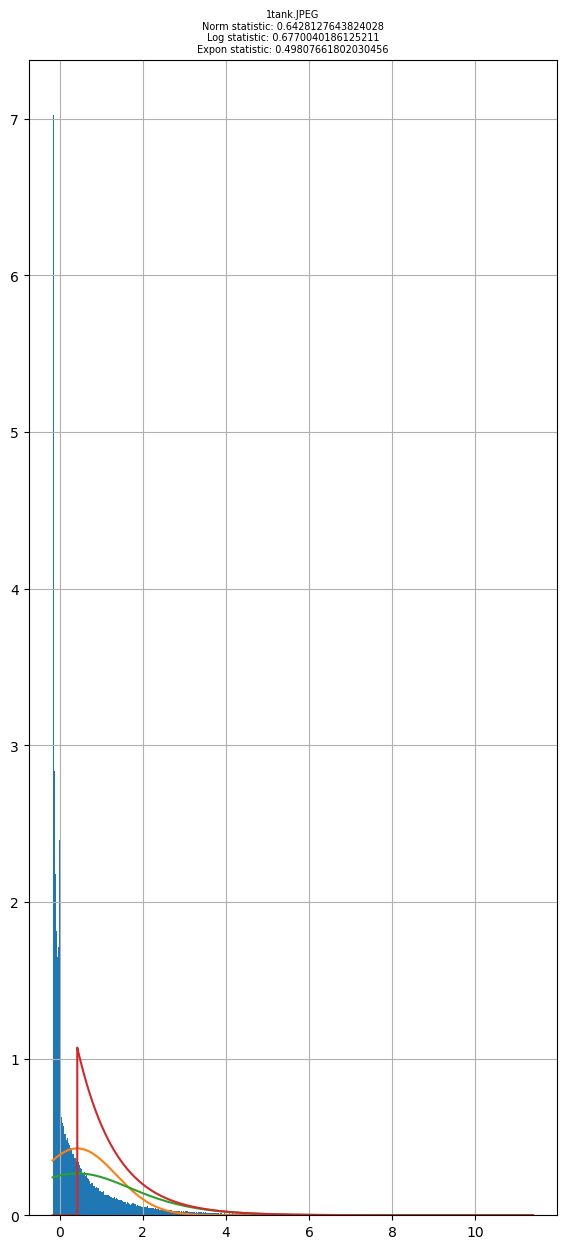

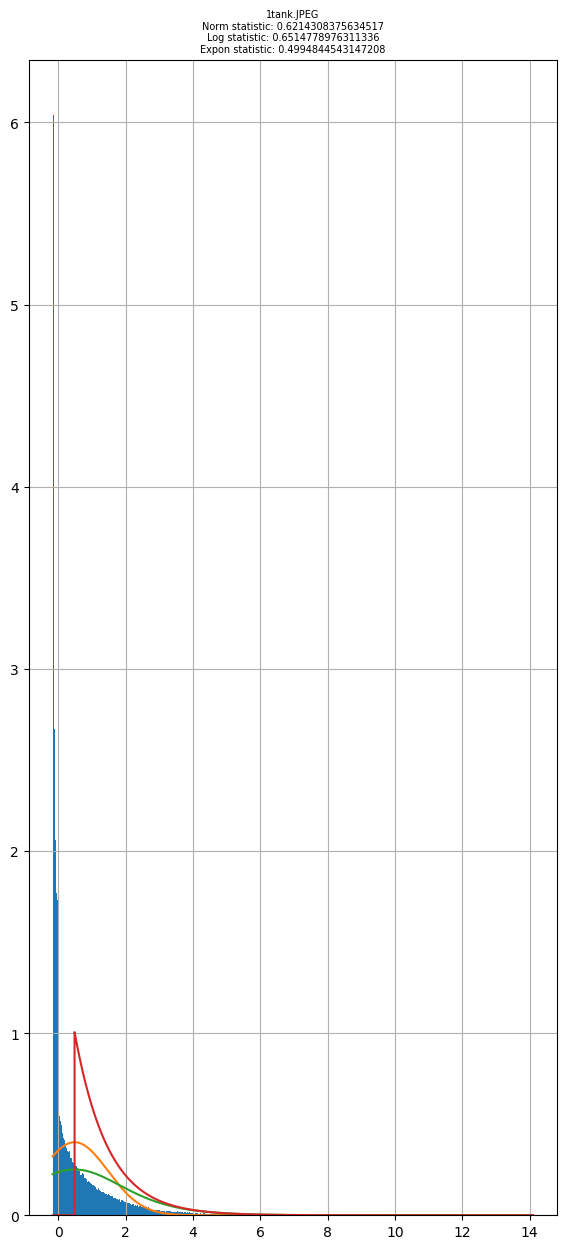

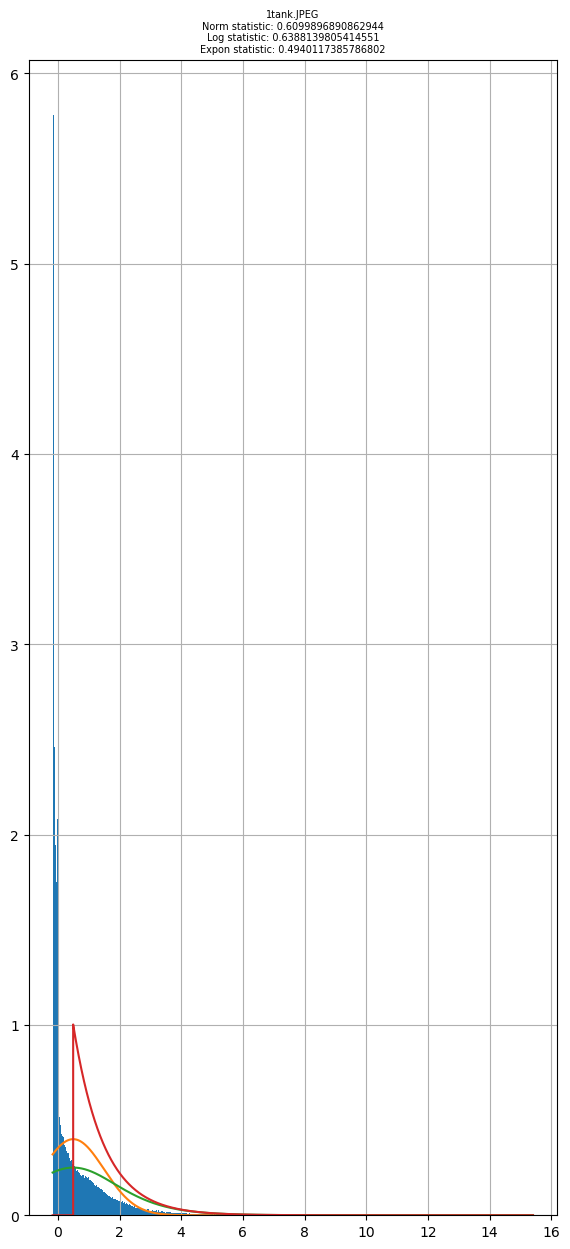

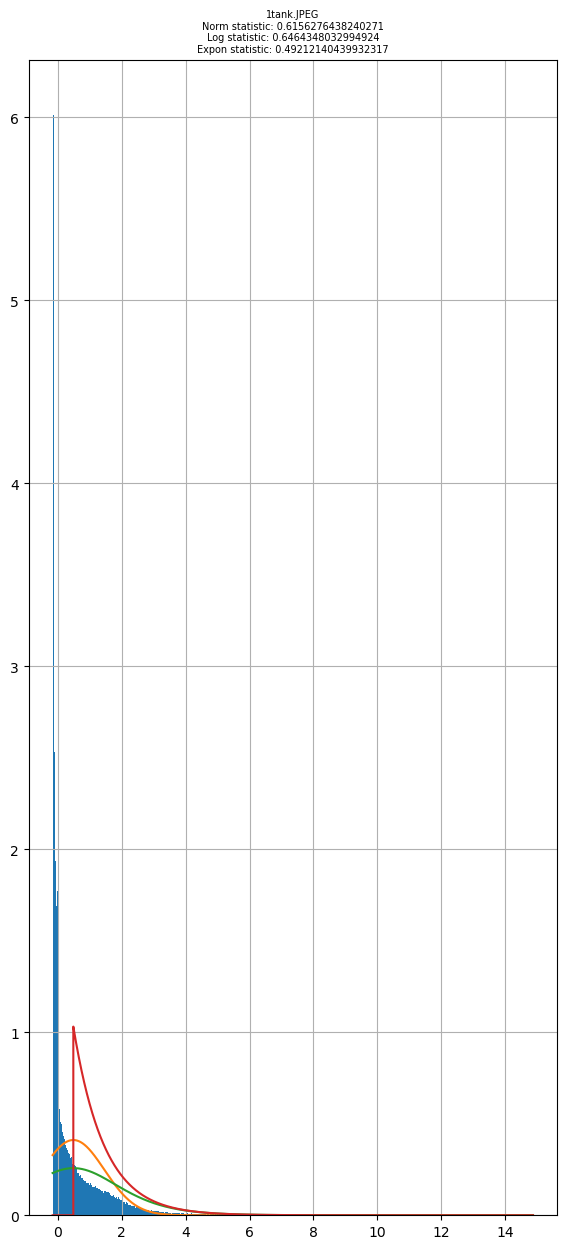

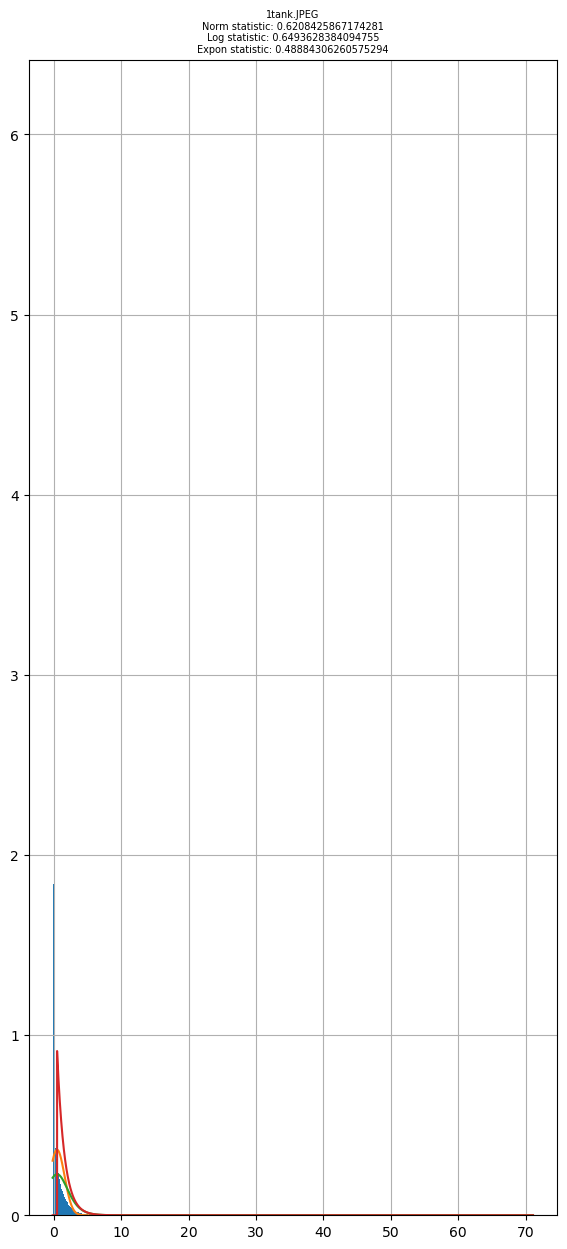

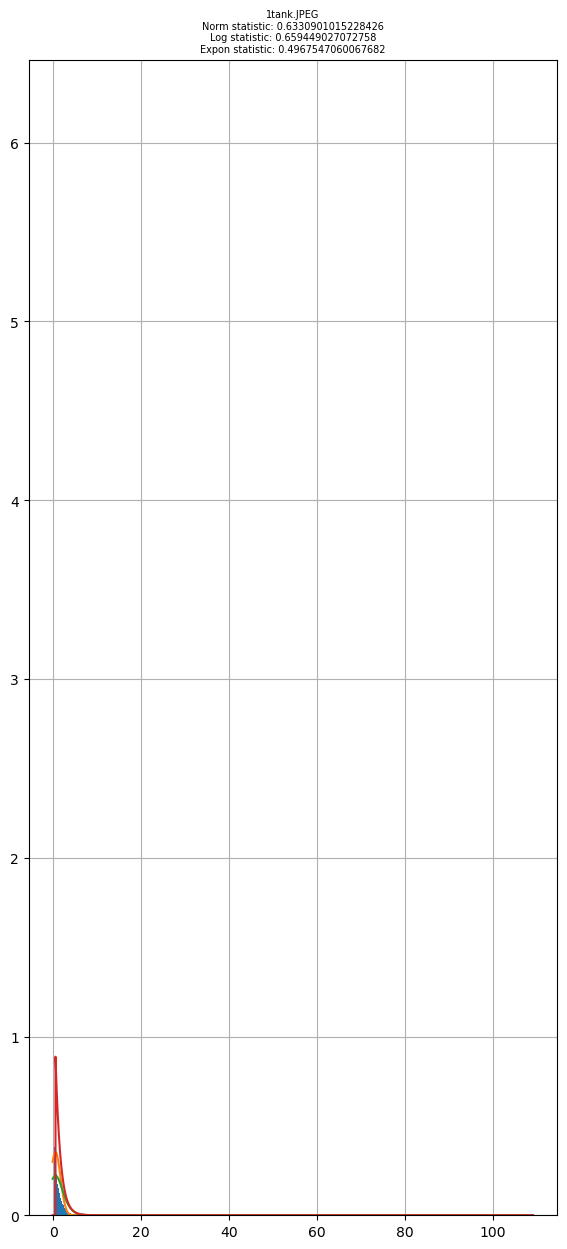

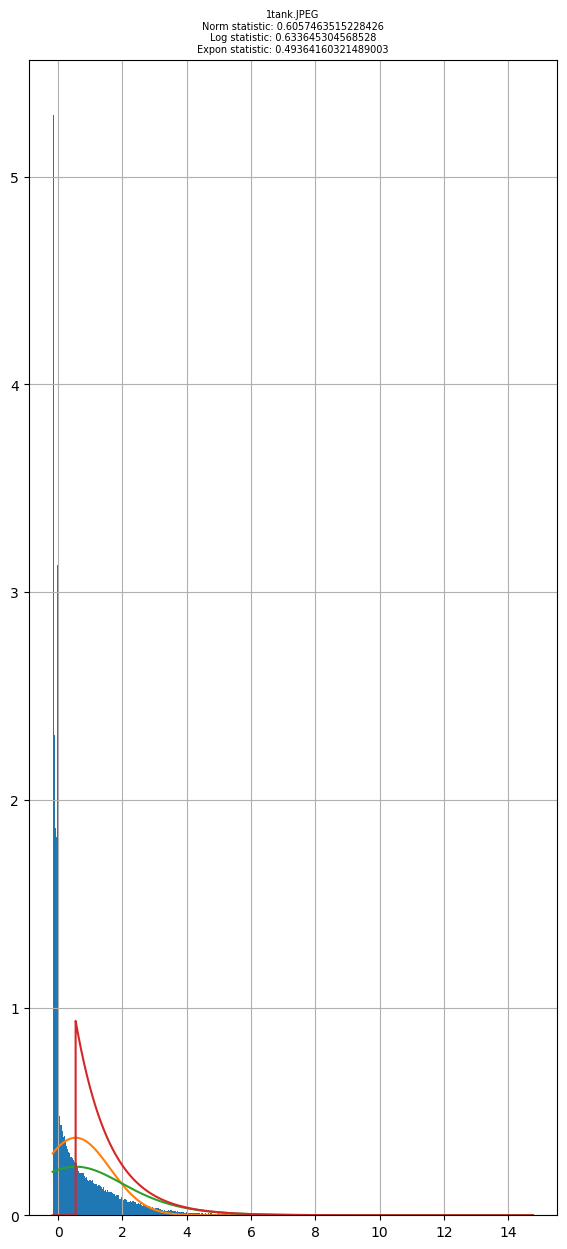

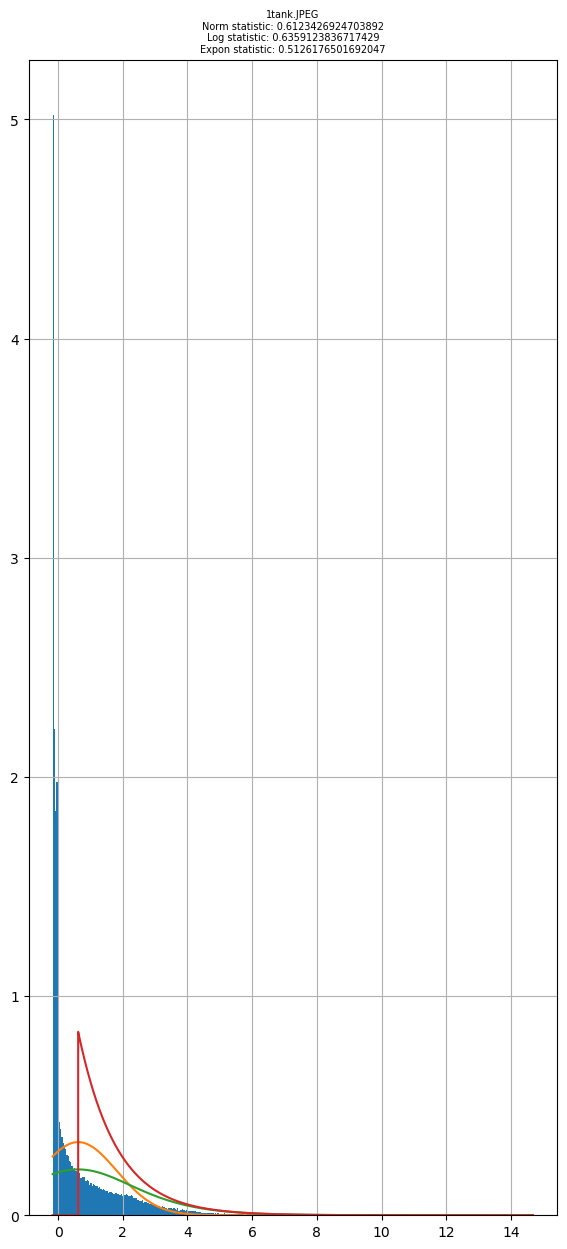

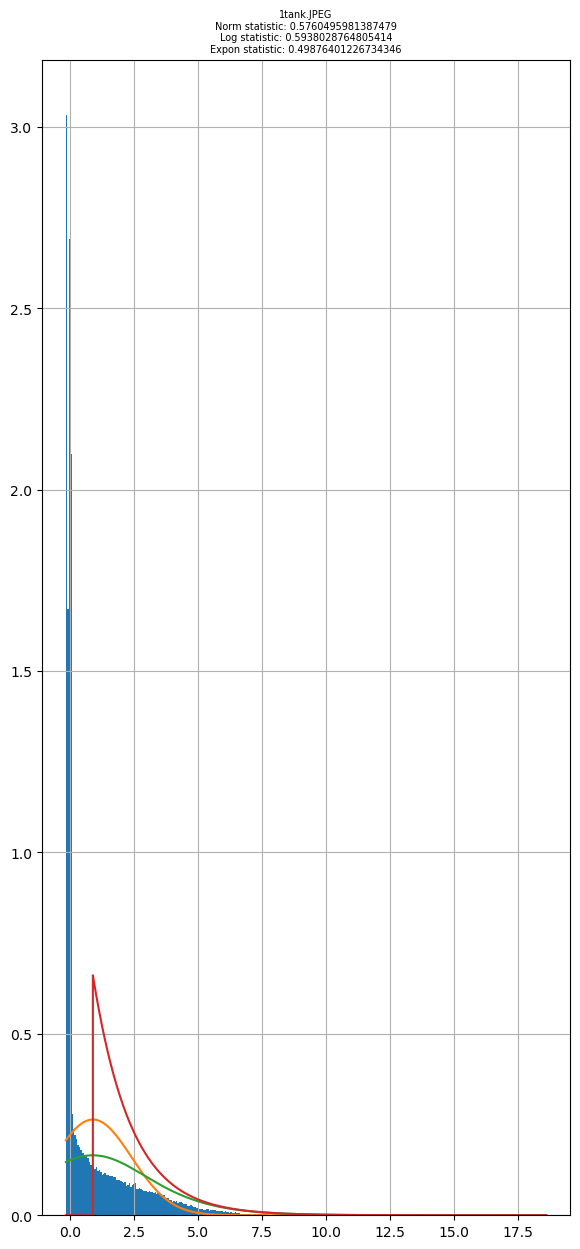

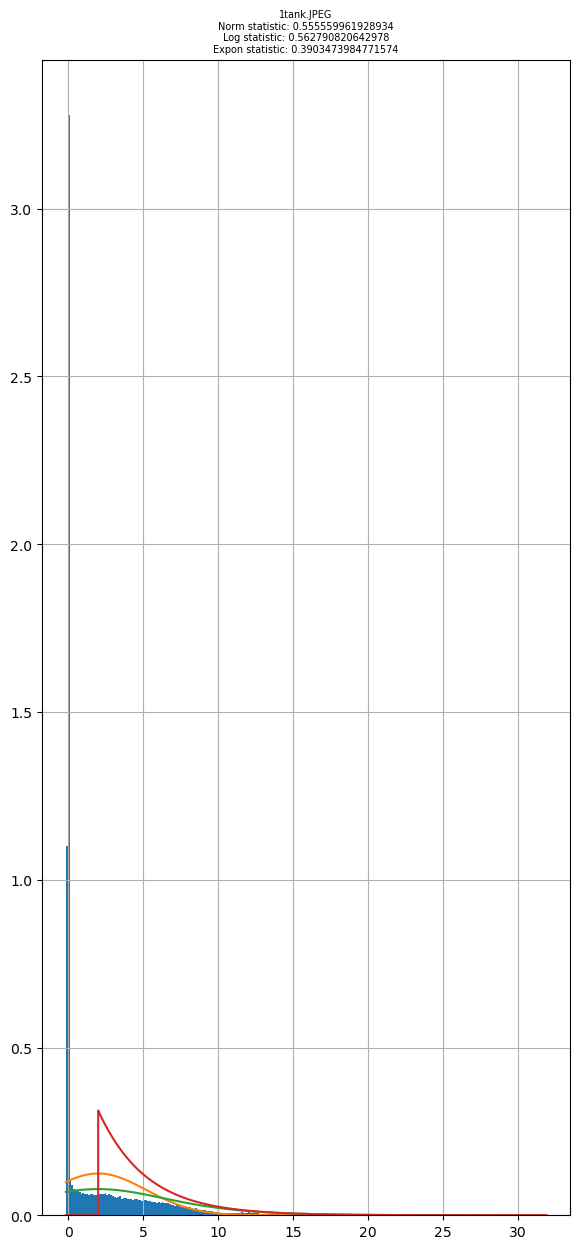

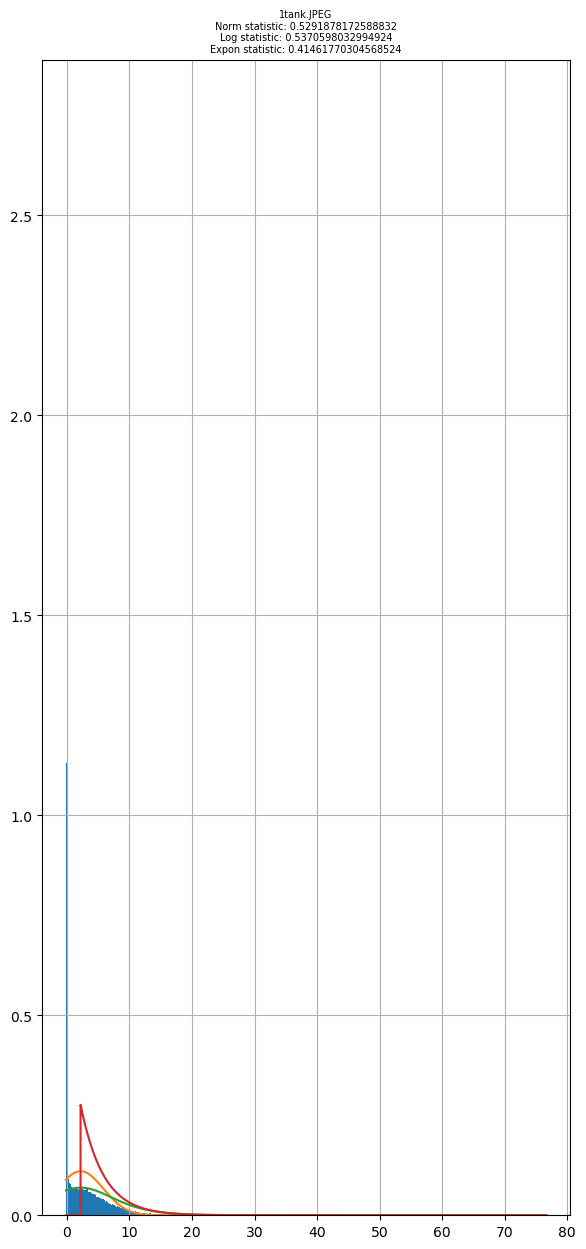

In [17]:
[showStatisticalVis(PATH_TO_SET, listOfAttentionWeightAfterPass[i].detach().numpy().reshape(1, 197 * 768)) for i in range(len(listOfAttentionWeightAfterPass))]